# IMPORT

In [8]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from tqdm import trange, tqdm
import time
import matplotlib.pyplot as plt
import random
from torch_geometric.nn import GCNConv, LayerNorm
from torch_geometric.utils import dropout_adj


# DATASET AND TRANSFORMATION

In [9]:
path = Path.cwd()


uav_df = pd.read_csv(path / 'UAVs.csv')
cluster_df = pd.read_csv(path / 'Clusters.csv')
items_df = pd.read_csv(path / 'Items.csv')

print('UAVs:', uav_df.shape)
print('Clusters:', cluster_df.shape)
print('Items:', items_df.shape)


UAVs: (20, 5)
Clusters: (100, 5)
Items: (1000, 3)


In [10]:

uav_features = torch.tensor(uav_df[['UAV_x', 'UAV_y', 'UAV_z', 'UAV_max_weight']].values, dtype=torch.float)



cluster_xy = cluster_df[['Cluster_x', 'Cluster_y']].values
cluster_people = cluster_df['People_count'].values.reshape(-1, 1)
cluster_item = cluster_df['Required_item_id'].values.reshape(-1, 1)
cluster_zero = np.zeros((cluster_df.shape[0], 1))
cluster_features = np.hstack([cluster_xy, cluster_zero, cluster_people, cluster_item])
cluster_features = torch.tensor(cluster_features, dtype=torch.float)
num_cluster = cluster_features.size(0)
cluster_pad = torch.zeros((num_cluster, 1), dtype=cluster_features.dtype)
cluster_padded = torch.cat([cluster_features, cluster_pad], dim=1)



pad = torch.zeros((uav_features.size(0), 2), dtype=torch.float)
uav_padded = torch.cat([uav_features, pad], dim=1)


num_uav, uav_dim = uav_features.shape
num_cluster, clu_dim = cluster_features.shape

feature_dim = max(uav_dim, clu_dim)


if uav_dim < feature_dim:
    pad = torch.zeros((num_uav, feature_dim - uav_dim))
    uav_padded = torch.cat([uav_features, pad], dim=1)
else:
    uav_padded = uav_features


if clu_dim < feature_dim:
    pad = torch.zeros((num_cluster, feature_dim - clu_dim))
    cluster_padded = torch.cat([cluster_features, pad], dim=1)
else:
    cluster_padded = cluster_features

x = torch.cat([uav_padded, cluster_features] , dim=0)
print('Node feature matrix x shape:', x.shape)


Node feature matrix x shape: torch.Size([120, 5])


# GRAPH CONSTRUCTION

In [11]:
num_uav     = uav_features.size(0)
num_cluster = cluster_features.size(0)
velocity    = 15.0  # m/s

edges      = []
edge_attrs = []

for u in range(num_uav):
    pos_u = uav_features[u, :3]
    for c in range(num_cluster):
        pos_c = cluster_features[c, :3]

   
        distance = torch.norm(pos_u - pos_c)
        time     = distance / velocity

        people  = int(cluster_df.iloc[c]['People_count'])
        item_id = int(cluster_df.iloc[c]['Required_item_id'])

        item_weight     = float(
            items_df.loc[items_df['Item_ID'] == item_id, 'Item_weight_per_person'].values[0]
        )
        item_importance = float(
            items_df.loc[items_df['Item_ID'] == item_id, 'Item_importance_score'].values[0]
        )

      
        total_weight = people * item_weight

        
        edge_feature = torch.tensor(
            [distance, time, total_weight, item_importance],
            dtype=torch.float
        )

        edges.append([u, num_uav + c])
        edge_attrs.append(edge_feature)


edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr  = torch.stack(edge_attrs)

print('Edge index shape:', edge_index.shape)      
print('Edge attributes shape:', edge_attr.shape)  

Edge index shape: torch.Size([2, 2000])
Edge attributes shape: torch.Size([2000, 4])


In [12]:
y = torch.randint(0, num_cluster, (num_uav,), dtype=torch.long)


data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
loader = DataLoader([data], batch_size=1)

print(data)


Data(x=[120, 5], edge_index=[2, 2000], edge_attr=[2000, 4], y=[20])


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# MODEL

In [13]:
class UAVClusterGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_uav, dropedge_prob=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.3)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.res_proj = torch.nn.Linear(in_channels, hidden_channels)  # ✅ Thêm projection
        self.num_uav = num_uav
        self.dropedge_prob = dropedge_prob
        #self.dropout_edge = dropnode

    def forward(self, x, edge_index, edge_attr=None):
        if self.training and self.dropedge_prob > 0:
            edge_index, _ = dropout_adj(edge_index, p=self.dropedge_prob, force_undirected=True, num_nodes=x.size(0))

        x_res = self.res_proj(x)  # ✅ lấy trước khi vào conv1, shape [N, 64] sau Linear

        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = x + x_res  # ✅ residual khớp chiều
        x = self.norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        uav_emb = x[:self.num_uav]
        return self.lin(uav_emb)

# TRAINING


Training with learning rate = 0.01


Training (lr=0.01):   0%|                                                   | 0/200 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
Training (lr=0.01): 100%|███████████████████████████| 200/200 [00:01<00:00, 100.49it/s, Loss=0.2730]



Training with learning rate = 0.001


Training (lr=0.001): 100%|███████████████████████████| 200/200 [00:02<00:00, 95.77it/s, Loss=2.1460]



Training with learning rate = 0.0001


Training (lr=0.0001): 100%|██████████████████████████| 200/200 [00:02<00:00, 90.72it/s, Loss=4.2176]


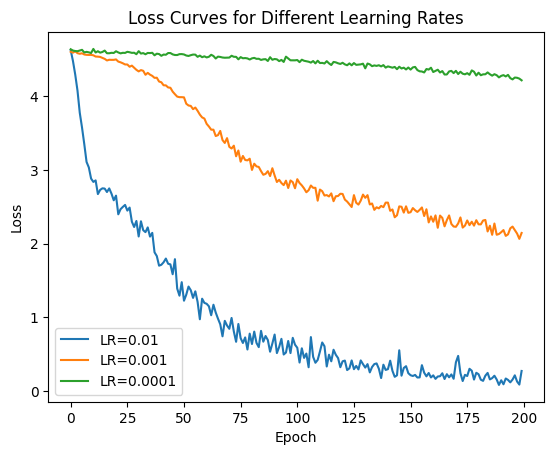

In [14]:
learning_rates = [1e-2, 1e-3, 1e-4]
num_epochs = 200
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

true_labels = torch.randint(0, num_cluster, (num_uav,), device=device)

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model = UAVClusterGCN(in_channels=data.x.size(1), hidden_channels=64, out_channels=num_cluster, num_uav=num_uav).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    with tqdm(range(1, num_epochs + 1), desc=f"Training (lr={lr})", ncols=100) as pbar:
        for epoch in pbar:
            model.train()
            optimizer.zero_grad()
            out = model(data.x.to(device), data.edge_index.to(device))
            loss = F.cross_entropy(out, true_labels)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    results[lr] = loss_history

# Plot loss curves
for lr, loss_hist in results.items():
    plt.plot(loss_hist, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves for Different Learning Rates")
plt.show()



# LOSS AND METRICS

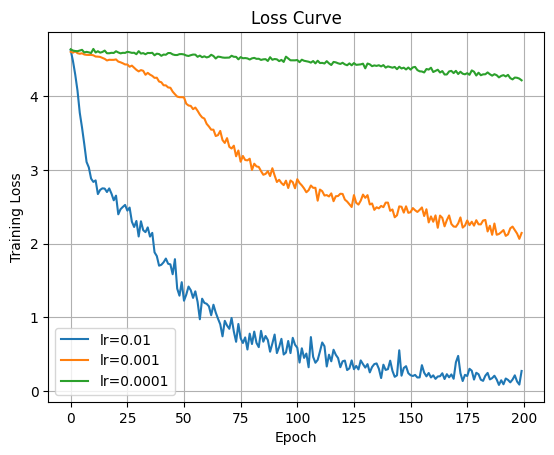

In [15]:
import matplotlib.pyplot as plt

plt.figure()
for lr, losses in results.items():
    plt.plot(losses, label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


# TRAINING WITH DIFFERENT EPOCHS    

In [16]:
def TRAINING(num_epoch, learning_rate, model_class, x, edge_index, y_true, num_uav, num_cluster, device):
    model = model_class(in_channels=x.size(1), hidden_channels=64,
                        out_channels=num_cluster, num_uav=num_uav).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x, edge_index, y_true = x.to(device), edge_index.to(device), y_true.to(device)

    for epoch in range(num_epoch):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = F.cross_entropy(out, y_true)  # Nếu dùng one-hot, thay bằng F.mse_loss(out, y_onehot)
        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
EPOCH_LIST = [100,200,300,500]
num_trials = 100
chart_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for num_epoch in EPOCH_LIST:
    trial_losses = []

    print(f"\n==> Đang huấn luyện với {num_epoch} epochs:")
    for _ in tqdm(range(num_trials), desc=f"Epochs={num_epoch}", ncols=100):
        loss = TRAINING(
            num_epoch=num_epoch,
            learning_rate=1e-2,
            model_class=UAVClusterGCN,
            x=data.x,
            edge_index=data.edge_index,
            y_true=true_labels,   # hoặc y_onehot nếu dùng MSE
            num_uav=num_uav,
            num_cluster=num_cluster,
            device=device
        )
        trial_losses.append(loss)

    # Tính thống kê
    chart_list.append((
        np.min(trial_losses),
        np.mean(trial_losses),
        np.max(trial_losses)
    ))

# ==== IN KẾT QUẢ ====
print("\n=== BẢNG THỐNG KÊ LOSS ===")
for i, epoch in enumerate(EPOCH_LIST):
    print(f"Epoch = {epoch:>3}: Min = {chart_list[i][0]:.4f} | Mean = {chart_list[i][1]:.4f} | Max = {chart_list[i][2]:.4f}")



==> Đang huấn luyện với 100 epochs:


Epochs=100:  52%|██████████████████████████                        | 52/100 [01:16<00:41,  1.16it/s]

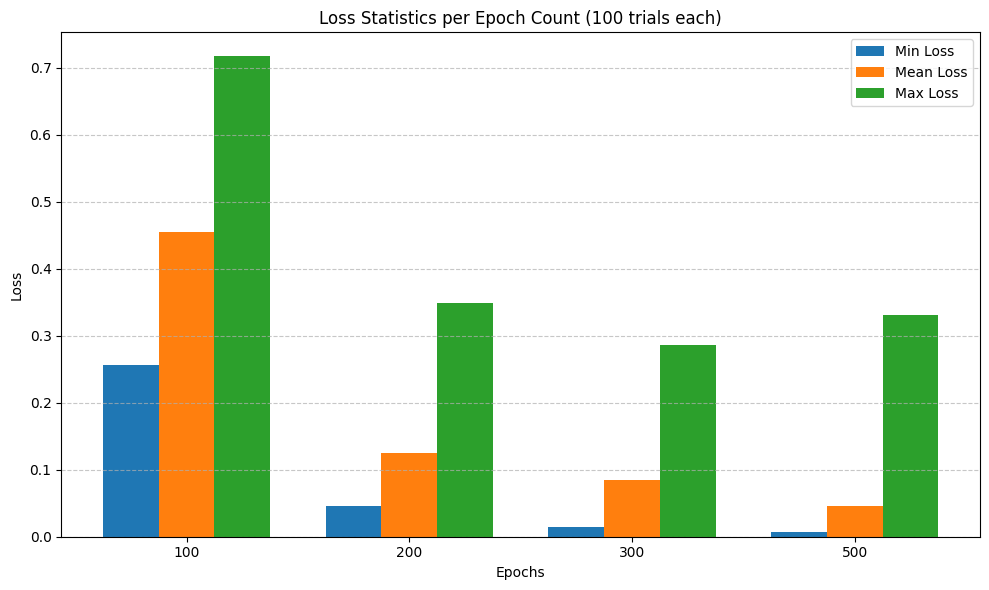

In [ ]:
min_vals, mean_vals, max_vals = zip(*chart_list)
x = np.arange(len(EPOCH_LIST))  # vị trí nhóm cột

bar_width = 0.25  # độ rộng mỗi cột
offsets = [-bar_width, 0, bar_width]  # vị trí lệch trái/trung tâm/phải

plt.figure(figsize=(10, 6))
plt.bar(x + offsets[0], min_vals, width=bar_width, label='Min Loss')
plt.bar(x + offsets[1], mean_vals, width=bar_width, label='Mean Loss')
plt.bar(x + offsets[2], max_vals, width=bar_width, label='Max Loss')

# Gắn nhãn
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Statistics per Epoch Count (100 trials each)")
plt.xticks(x, EPOCH_LIST)  # Gắn nhãn trục x theo số epoch
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


🔁 Đang chạy EPOCH = 200


EPOCH=200: 100%|████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.40s/it]



🔁 Đang chạy EPOCH = 300


EPOCH=300: 100%|████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.13s/it]



🔁 Đang chạy EPOCH = 500


EPOCH=500: 100%|████████████████████████████████████████████████████| 50/50 [02:56<00:00,  3.53s/it]


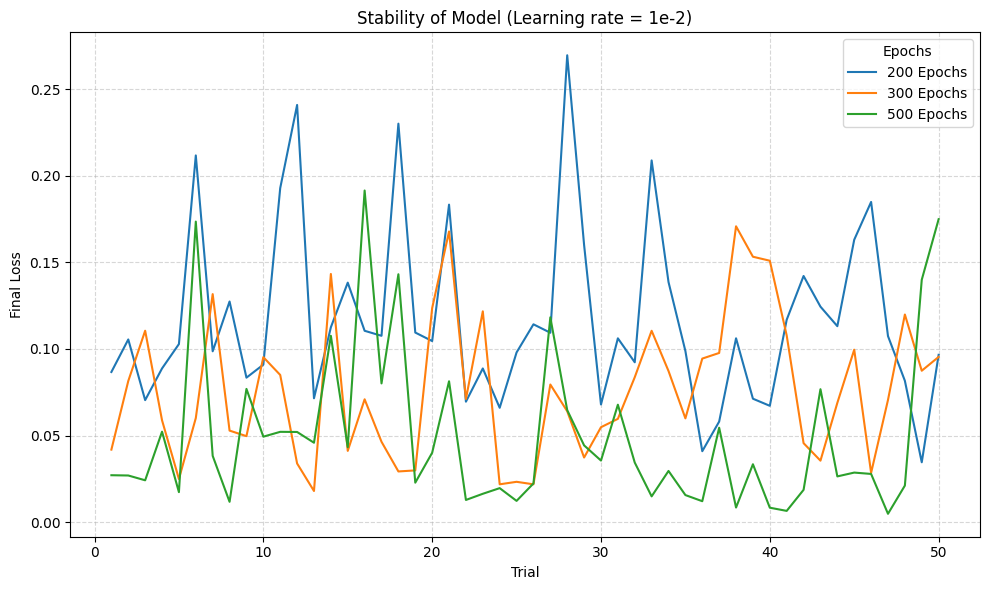

In [ ]:
EPOCH = [200,300,500]
num_trials = 50
final_loss = [[] for _ in range(len(EPOCH))]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(len(EPOCH)):
    print(f"\n🔁 Đang chạy EPOCH = {EPOCH[i]}")
    for j in tqdm(range(num_trials), desc=f"EPOCH={EPOCH[i]}", ncols=100):
        loss = TRAINING(
            num_epoch=EPOCH[i],
            learning_rate=1e-2,
            model_class=UAVClusterGCN,
            x=data.x,
            edge_index=data.edge_index,
            y_true=true_labels,   # hoặc y_onehot nếu dùng MSE
            num_uav=num_uav,
            num_cluster=num_cluster,
            device=device
        )
        final_loss[i].append(loss)  # ✅ lưu giá trị loss thực (float)

# ==== Vẽ biểu đồ stability ====
x_axis = np.arange(1, num_trials + 1)

plt.figure(figsize=(10, 6))
for i in range(len(EPOCH)):
    plt.plot(x_axis, final_loss[i], label=f"{EPOCH[i]} Epochs")

plt.title("Stability of Model (Learning rate = 1e-2)")
plt.xlabel("Trial")
plt.ylabel("Final Loss")
plt.legend(title="Epochs")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Standard Deviation of Final Loss

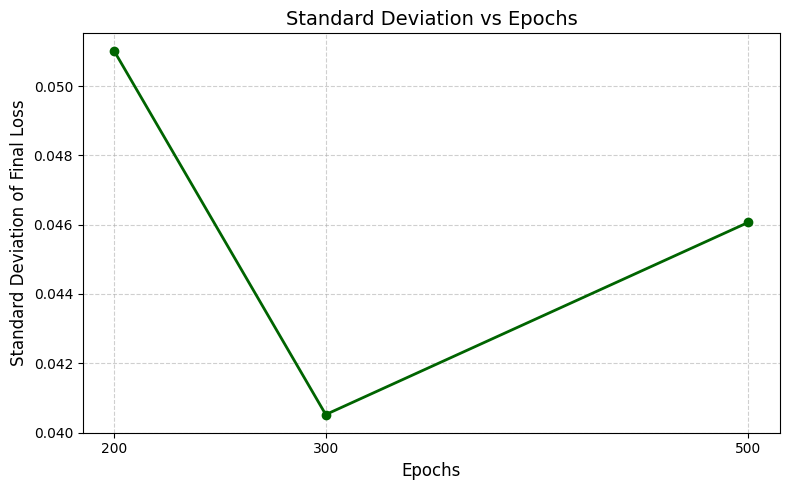

In [ ]:
std_vals = [np.std(losses) for losses in final_loss]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(EPOCH, std_vals, marker='o', linestyle='-', color='darkgreen', linewidth=2)

# Ghi nhãn
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Standard Deviation of Final Loss", fontsize=12)
plt.title("Standard Deviation vs Epochs", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(EPOCH)
plt.tight_layout()
plt.show()